# Домашнее задание

С помощью CNN решить задачу множественной классификации изображений, в качестве данных использовать датасет CIFAR-10. Добиться точности классификации на тестовой выборке не менее 80% (для полного балла за ДЗ). Провести анализ ошибок - вычислить и построить гистограммы precision и recall для каждого класса, построить графики зависимости ошибок и точности тестовой и обучающей выборок в зависимости от эпох обучения.

**В ДЗ можно пользоваться кодом из лекции**

In [ ]:
import torch
import torch.nn as nn
import torchvision
from collections import defaultdict
import time
#from torchsummary import summary
from torchinfo import summary
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

device_num = 0
device = f"cuda:{device_num}" if torch.cuda.is_available() else "mps"

print(f"Device: {device}")


Device: mps


In [ ]:
import platform
print(platform.platform())

macOS-13.1-arm64-arm-64bit


1) **Cоздайте класс сети**

In [ ]:
# Создаем класс сверточной нейронной сети
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(            
          # Блок 1: Свёртка с большим ядром, чтобы уловить общие закономерности

          # your code here
          nn.Conv2d(3, 16, kernel_size=5, padding=2),

          # Важно! Батч-нормализация всегда идёт до функции активации!
          nn.BatchNorm2d(16),
          nn.MaxPool2d(2),
          nn.Dropout(0.2),

          # Блок 2: Свёртка с ядром поменьше, выделяет более тонкие признаки.

          # your code here
          nn.Conv2d(16, 32, kernel_size=3, padding=1),

          nn.BatchNorm2d(32),
          nn.MaxPool2d(2),
          # Важно! Дропаут идёт после функции активации!
          nn.Dropout(0.2)

        )
        #Выход 8x8x32

        self.classifier = nn.Sequential(
          # Блок 3: Линейный слой поверх карт активации

          # your code here
          nn.Linear(2048, 512),

          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Dropout(0.2),

          # Блок 4: Классификационный слой
          nn.Linear(512, 10)
          
          # your code here
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Переносим CNN на device
model = MyCNN().to(device) 
print(f"Device: {device}")
  
  # your code here
  # Hint: возможно стоит попробовать готовые и даже уже предобученные сети (наподобие VGG с лекции)
  # Hint: если вы хотите написать свою сеть, используйте те же слои, которые мы разбирали на лекции (следите за порядком слоев!)

Device: mps


In [ ]:
# Посмотрим на порядок модели
model

MyCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

2) **Загрузите датасет и разбейте его на train и test**

In [ ]:
# загружаем тренировочный датасет CIFAR10
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
test_dataset_predict = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
test_dataset_predict.data.shape

Files already downloaded and verified
Files already downloaded and verified


(10000, 32, 32, 3)

In [ ]:
#Обратите внимание что теперь 10 уникальных классов (не 2 как в лекции)
print(np.unique(dataset.targets))
np.array(dataset.targets).shape

[0 1 2 3 4 5 6 7 8 9]


(50000,)

In [ ]:
#Размер всего датасета
print(dataset.data.shape)

(50000, 32, 32, 3)


In [ ]:
# Посмотрим на модель и на количество параметров в каждом слое
#проверить аргумент 1
summary(model, (1, 3, 32, 32), device = device)

Layer (type:depth-idx)                   Output Shape              Param #
MyCNN                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           1,216
│    └─BatchNorm2d: 2-2                  [1, 16, 32, 32]           32
│    └─MaxPool2d: 2-3                    [1, 16, 16, 16]           --
│    └─Dropout: 2-4                      [1, 16, 16, 16]           --
│    └─Conv2d: 2-5                       [1, 32, 16, 16]           4,640
│    └─BatchNorm2d: 2-6                  [1, 32, 16, 16]           64
│    └─MaxPool2d: 2-7                    [1, 32, 8, 8]             --
│    └─Dropout: 2-8                      [1, 32, 8, 8]             --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-9                       [1, 512]                  1,049,088
│    └─BatchNorm1d: 2-10                 [1, 512]                  1,024

In [ ]:
#Делим датасет на тренировочную и тестовую части
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [40000, 10000]
)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
batch_size_train = 64
batch_size_val = 1000
batch_size_test = 10000
#Загрузчик для тренировочного сета
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size_train, shuffle=True)

#Загрузчик для тестового сета
test_loader =  torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size_val, shuffle=True)
#Загрузчик для окончательного тестового сета
test_loader_predict =  torch.utils.data.DataLoader(
  test_dataset_predict,
  batch_size=batch_size_test, shuffle=False)

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['test'], label='test')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['test'], label='test')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

3) **Обучите сеть**

In [ ]:
#функция обучения модели
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    test_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации    
        for X_batch, y_batch in test_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Так как это не обучающие батчи, градиент не нужен
            with torch.no_grad():
                logits = model(X_batch)
                
            loss = criterion(logits, y_batch.long().to(device))
            test_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            test_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        test_loss /= len(test_batch_gen)
        test_acc /= len(test_batch_gen) 
        history['loss']['test'].append(test_loss)
        history['acc']['test'].append(test_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  test loss (in-iteration): \t{:.6f}".format(test_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  test accuracy: \t\t\t{:.2f} %".format(test_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Epoch 37 of 37 took 9.079s
  training loss (in-iteration): 	0.396269
  test loss (in-iteration): 	0.957642
  training accuracy: 			86.83 %
  test accuracy: 			69.20 %


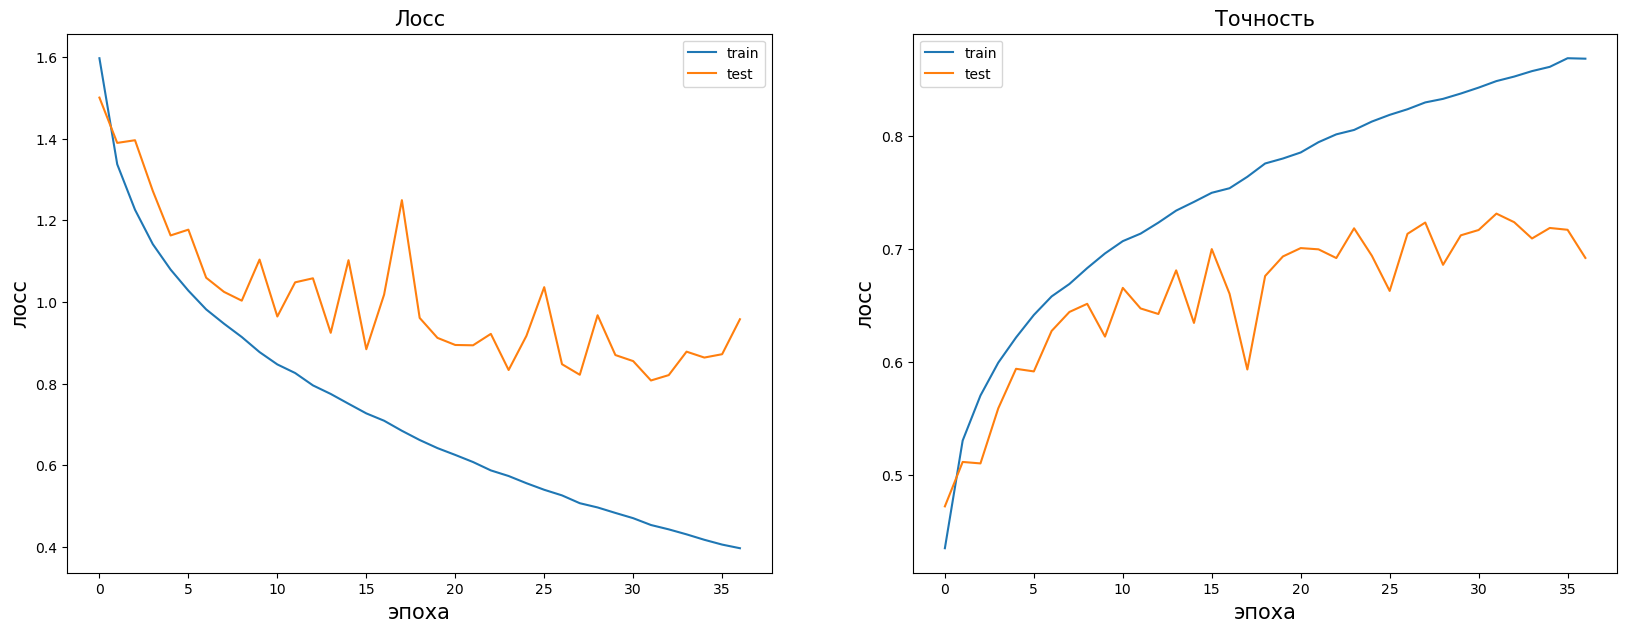

In [ ]:
# Зададим функциию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()# your code here 
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)# your code here
optimizer = optim.Adam(model.parameters(), lr = 0.0001, eps = 0.00000001, betas = (0.9, 0.999))
 
# Обучим модель
model, history = train(
    model, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=37
)



4) **Построите графики обучения и проанализируйте ошибки сети, сделайте выводы**

In [ ]:
#сделаем предсказания на окончательной тестовой выборке из  10000 элементов, посчитаем accuracy, 
test_acc = 0
for X_batch, y_batch in test_loader_predict:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
            
            # Так как это не обучающие батчи, градиент не нужен
    with torch.no_grad():
        output = model(X_batch)
                
        loss = criterion(logits, y_batch.long().to(device))
        y_pred = output.max(1)[1].detach().cpu().numpy()
        test_acc += np.mean(y_batch.cpu().numpy() == y_pred)


In [ ]:
#посмотрим получившуюся accuracy
test_acc

0.6909

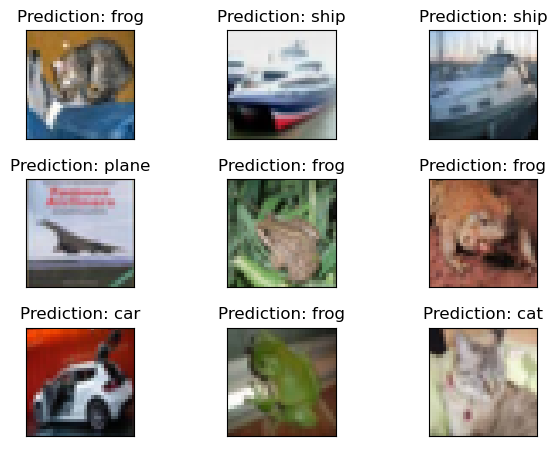

In [ ]:
# получим 9 получившихся меток с соответственными картинками
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(np.transpose(X_batch[i].cpu().numpy(), (1, 2, 0)), interpolation='none')
  plt.title(f"Prediction: {classes[output.data.max(1, keepdim=True)[1][i].item()]}")
  plt.xticks([])
  plt.yticks([])

/Users/shmykovaanna/opt/anaconda3/envs/m1/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


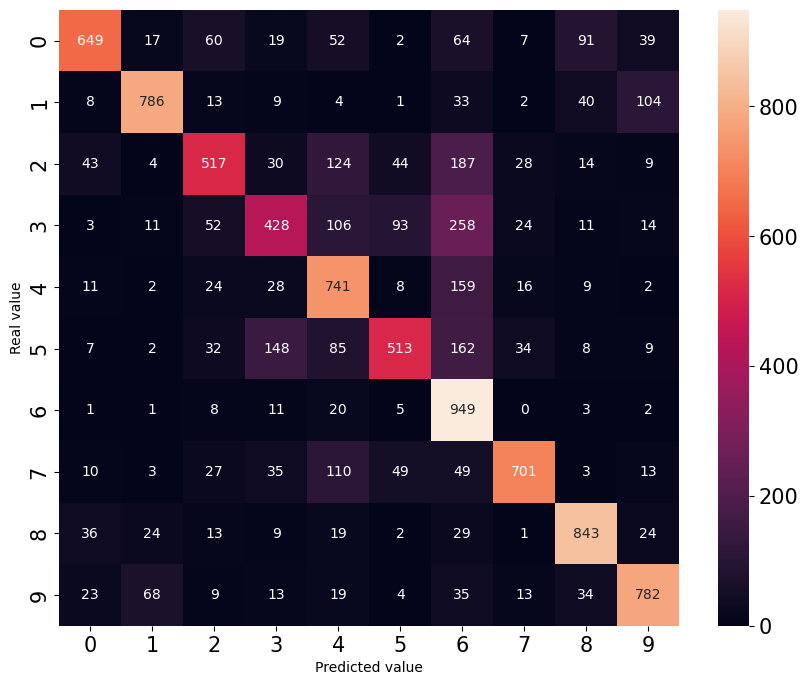

In [ ]:
#получим confusion_matrix
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix
mp_mtx = confusion_matrix(y_batch.cpu().numpy(), y_pred)
fig = plt.figure(figsize=(10,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
sns.heatmap(mp_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.show()

In [ ]:
# посчитаем по матрице ошибок по каждому классу precision, recall, занесем их в словарь
recall_precision = {}
for i, cl in enumerate(classes):
    recall_precision[cl] = [mp_mtx[i, i]/ mp_mtx[:, i].sum()]
    recall_precision[cl].append(mp_mtx[i, i]/ mp_mtx[i].sum())

In [ ]:
#образуем таблицу на основании получившегося словаря
import pandas as pd
r_p = pd.DataFrame(recall_precision).T
r_p.rename(columns = {0: 'Recall', 1: 'Precision'}, inplace = True)
r_p

,Recall,Precision
plane,0.820480,0.649
car,0.856209,0.786
bird,0.684768,0.517
cat,0.586301,0.428
deer,0.578906,0.741
dog,0.711512,0.513
frog,0.492987,0.949
horse,0.848668,0.701
ship,0.798295,0.843
truck,0.783567,0.782


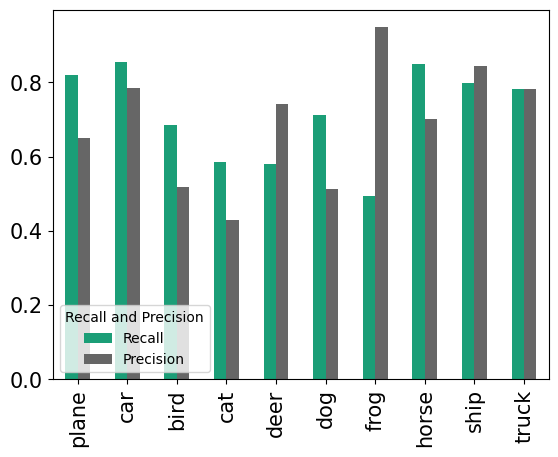

In [ ]:
#посмотрим визуально получившиеся результаты
import matplotlib as plt
r_p_bar = r_p.plot(kind = 'bar', cmap='Dark2').legend(loc = 'lower left')
r_p_bar.set_title("Recall and Precision")

In [ ]:
Вывод: Модель на тренировочной выборке работает неплохо, на валидационной выборке она показывает себя значительно хуже. На тестовой выборке
    она тоже показывает accuracy 0.7, после 30 эпохи начинается ухудшение качества модели, то есть около 30 эпохи надо остановить обучение.
    Мне кажется, что не хватает данных для лучшего обучения, и достаточно быстро происходит переобучение.
    Получившаяся модель лучше всего распознает такие классы: car, ship, truck, хуже всего класс cat.